In [70]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from scipy.signal import convolve2d
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import eigsh, eigs
import os
import cv2
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv
import time

In [ ]:
(data, label), _ = mnist.load_data()
print('Shape of data:', data.shape)
print('Number of labels:', len(label))

Shape of data: (60000, 28, 28)
Number of labels: 60000


In [ ]:
def smooth(img, filter_size=3, num_iter=2):
    average_filter = np.ones((filter_size, filter_size)) / (filter_size ** 2)

    for i in range(num_iter):
        smoothed_img = convolve2d(img, average_filter, mode='same')

    return smoothed_img

data_smoothed = np.array([smooth(img) for img in data])

In [ ]:
# flatten
data_flatten = data_smoothed.reshape(data_smoothed.shape[0], -1)

pca = PCA(n_components=50)
data_pca = pca.fit_transform(data_flatten)

data_pca.shape

(60000, 50)

In [ ]:
def graph_construction(X, k, m, sigma=1):
    """
    X: data
    k: k-th neareast neighbors
    m: self-tuning neighbor index (m<k)
    sigma: local time
    """

    # includes the point itself as the 0-th nearest
    knn = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='euclidean')

    knn.fit(X)

    # Get the k nearest neighbors for each data point
    distances, indices = knn.kneighbors(X)

    # Compute self-tuning weights
    num_points = X.shape[0]
    W_dense = np.zeros((num_points, num_points))

    for i in range(num_points):
        # j-th neareast neighbor for normalization
        for j in range(k+1):
            # Normalize distances by the m-th nearest neighbor of i
            rho_x = distances[i, j] / distances[i, m]
            # Normalize distances by the m-th nearest neighbor of  j
            rho_y = distances[i, j] / distances[indices[i, j], m]
            weight = np.exp(-(rho_x * rho_y) / sigma)
            # Assign weight symmetrically
            W_dense[i, indices[i, j]] += weight
            W_dense[indices[i, j], i] += weight

    # create self-tuning weight matrix
    W_dense /= 2
    # Convert dense matrix to sparse format
    W = csr_matrix(W_dense)

    return W

In [ ]:
def random_walk(W):
    # compute the diagonal matrix D
    D = np.diag(np.array(W.sum(axis=1)).flatten())
    # compute the random walk matrix K
    K = np.linalg.inv(D) @ W

    return K

def harmonic_classifier(labels, labeled_indices, K, iterations, num_classes=10):
    num_nodes = len(labels)
    label_probabilities = np.zeros((num_nodes, num_classes))

    for class_index in range(num_classes):
        is_current_class = (labels == class_index).astype(int)
        class_probabilities = np.zeros(num_nodes)
        class_probabilities[labeled_indices] = is_current_class[labeled_indices]

        for _ in range(iterations):
            class_probabilities = K.dot(class_probabilities)
            class_probabilities[labeled_indices] = is_current_class[labeled_indices]

        label_probabilities[:, class_index] = class_probabilities

    # Normalize the probabilities to make the rows sum to 1
    # label_probabilities = label_probabilities / label_probabilities.sum(axis=1, keepdims=True)
    return label_probabilities


In [ ]:
# def harmonic_classifier(y, labeled_indices, K, num_classes=10, steps=250):
#     n = len(y)
#     f = np.zeros((n, num_classes))

#     # Initialize f with the labeled data
#     for i, idx in enumerate(labeled_indices):
#         f[idx, y[i]] = 1

#     for _ in range(steps):
#         f = K @ f

#         # Reset the labeled data to their original values
#         for i, idx in enumerate(labeled_indices):
#             f[idx] = 0
#             f[idx, y[i]] = 1

#     return f

In [ ]:
img = data_pca[:10000]
labels = label[:10000]



# # graph construction
# W = graph_construction(img, k=9, m=8, sigma=1)
# K = random_walk(W)



In [ ]:
def calculate_error(predicted, actual, start_index, total_samples):
    errors = sum(1 for i in range(start_index, total_samples) if predicted[i] != actual[i])
    error_rate = errors / (total_samples - start_index)
    return error_rate

In [ ]:
def kernel_smooth(labels, labeled_indices, W, num_classes=10, iterations=iter):
    K = random_walk(W)  # 使用随机游走矩阵K
    num_nodes = len(labels)
    label_probabilities = np.zeros((num_nodes, num_classes))

    for class_index in range(num_classes):
        is_current_class = (labels == class_index).astype(int)
        class_probabilities = np.zeros(num_nodes)
        # 添加平滑处理
        smoothed_labels = np.full(num_nodes, 0.1)  # 平滑参数可以调整
        class_probabilities[labeled_indices] = is_current_class[labeled_indices] + smoothed_labels[labeled_indices]

        for _ in range(iterations):
            class_probabilities = K.dot(class_probabilities)

        label_probabilities[:, class_index] = class_probabilities
    return label_probabilities

In [ ]:
W = graph_construction(img, k=9, m=8, sigma=1)
K = random_walk(W)

In [ ]:

# iterations_list = range(5, 100, 10)
# error_rates_kernel = []
# error_rates_harmonic = []

# # Running loop for kernel_smooth
# for iters in iterations_list:
#     predicted_probabilities = kernel_smooth(labels, labeled_indices=500, W, iterations=iters)
#     predicted_labels = np.argmax(predicted_probabilities, axis=1)
#     error_kernel = calculate_error(predicted_labels, labels, 0, 10000)
#     error_rates_kernel.append(error_kernel)
#     print(f'Kernel Smoothing Error at {iters} iterations: {error_kernel}')

# # Running loop for harmonic_classifier
# for iters in iterations_list:
#     predicted_probabilities_h = harmonic_classifier(labels, labeled_indices=500, K, iters)
#     predicted_labels_h = np.argmax(predicted_probabilities_h, axis=1)
#     error_harmonic = calculate_error(predicted_labels_h, labels, 0, 10000)
#     error_rates_harmonic.append(error_harmonic)
#     print(f'Harmonic Classifier Error at {iters} iterations: {error_harmonic}')




Kernel Smoothing Error at 5 iterations: 0.0652
Kernel Smoothing Error at 15 iterations: 0.0621
Kernel Smoothing Error at 25 iterations: 0.0739
Kernel Smoothing Error at 35 iterations: 0.0882
Kernel Smoothing Error at 45 iterations: 0.0955
Kernel Smoothing Error at 55 iterations: 0.1008
Kernel Smoothing Error at 65 iterations: 0.1078
Kernel Smoothing Error at 75 iterations: 0.1148
Kernel Smoothing Error at 85 iterations: 0.123
Kernel Smoothing Error at 95 iterations: 0.1304
Harmonic Classifier Error at 5 iterations: 0.0796
Harmonic Classifier Error at 15 iterations: 0.0561
Harmonic Classifier Error at 25 iterations: 0.0535
Harmonic Classifier Error at 35 iterations: 0.0517
Harmonic Classifier Error at 45 iterations: 0.0512
Harmonic Classifier Error at 55 iterations: 0.0513
Harmonic Classifier Error at 65 iterations: 0.0516
Harmonic Classifier Error at 75 iterations: 0.0515
Harmonic Classifier Error at 85 iterations: 0.0514
Harmonic Classifier Error at 95 iterations: 0.0514


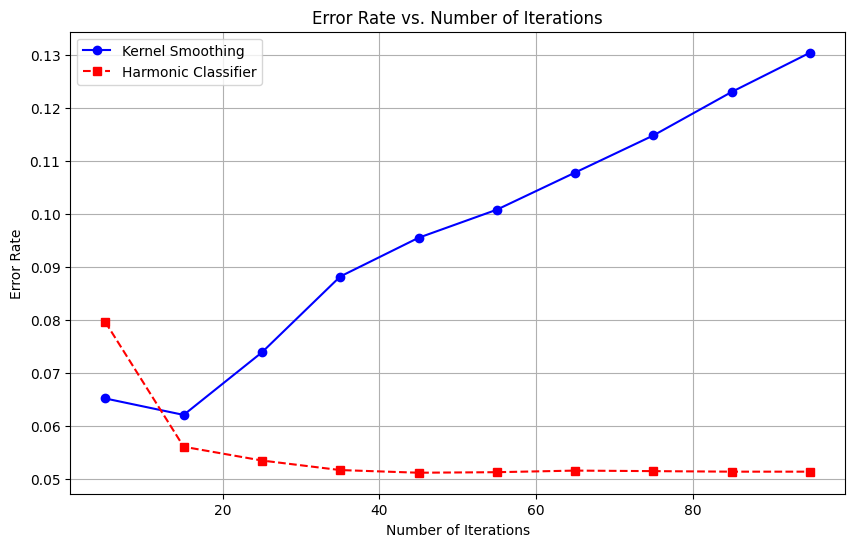

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(list(iterations_list), error_rates_kernel, marker='o', linestyle='-', color='blue', label='Kernel Smoothing')
plt.plot(list(iterations_list), error_rates_harmonic, marker='s', linestyle='--', color='red', label='Harmonic Classifier')
plt.title('Error Rate vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def data_split(num_img, num_labeled, num_split):
    """
    split data into labeled and unlabeled for cross validation

    return: indices of labeled and unlabeled data
    """
    labeled_indices = []
    unlabeled_indices = []
    for split in range(num_split):
        indices = np.random.permutation(num_img)
        labeled = indices[:num_labeled]
        unlabeled = indices[num_labeled:]
        labeled_indices.append(labeled)
        unlabeled_indices.append(unlabeled)

    return labeled_indices, unlabeled_indices

In [ ]:

# num_labeled = [100, 250, 500, 1000, 2500, 5000]
# num_split = 10
# error_rates_kernel_2 = []
# error_rates_harmonic_2 = []

# for num in num_labeled:
#     labeled_indices, unlabeled_indices = data_split(10000, num, num_split)

#     predicted_probabilities = kernel_smooth(labels, labeled_indices, W, iterations=50)
#     predicted_probabilities_h = harmonic_classifier(labels, labeled_indices, K, iterations=50)

#     predicted_labels = np.argmax(predicted_probabilities, axis=1)
#     predicted_labels_h = np.argmax(predicted_probabilities_h, axis=1)

#     error_kernel = calculate_error(predicted_labels, labels, 0, 10000)
#     error_harmonic = calculate_error(predicted_labels_h, labels, 0, 10000)

#     error_rates_kernel_2.append(error_kernel)
#     error_rates_harmonic_2.append(error_harmonic)
#     print(f'Kernel Error for {num} labeled data: {error_kernel}')
#     print(f'Harmonic Error for {num} labeled data: {error_harmonic}')





Kernel Error for 100 labeled data: 0.0645
Harmonic Error for 100 labeled data: 0.0379
Kernel Error for 250 labeled data: 0.0878
Harmonic Error for 250 labeled data: 0.0276
Kernel Error for 500 labeled data: 0.0713
Harmonic Error for 500 labeled data: 0.0197
Kernel Error for 1000 labeled data: 0.0757
Harmonic Error for 1000 labeled data: 0.0111
Kernel Error for 2500 labeled data: 0.0745
Harmonic Error for 2500 labeled data: 0.0016
Kernel Error for 5000 labeled data: 0.074
Harmonic Error for 5000 labeled data: 0.0


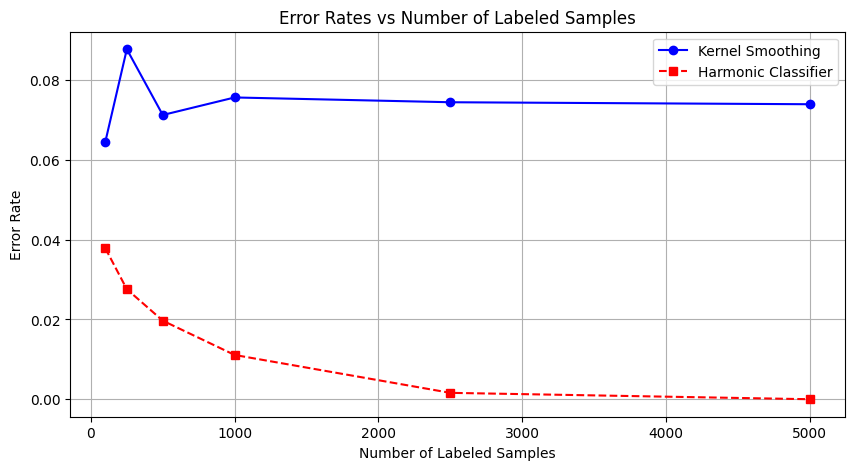

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(list(num_labeled), error_rates_kernel_2, marker='o', linestyle='-', color='blue', label='Kernel Smoothing')
plt.plot(list(num_labeled), error_rates_harmonic_2, marker='s', linestyle='--', color='red', label='Harmonic Classifier')
plt.title('Error Rates vs Number of Labeled Samples')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
error_rates_kernel_2

[0.0645, 0.0878, 0.0713, 0.0757, 0.0745, 0.074]

In [ ]:
def compute_adapted_weights(X, K,labels,labeled_indices,beta, m=8, k=9):
    g = harmonic_classifier(labels, labeled_indices, K, iterations =250, num_classes=10)
    c = g/(np.abs(g).sum(axis =0)[np.newaxis,:])

    c_normalized = c * (np.mean(np.linalg.norm(X, axis=1)) / np.mean(np.linalg.norm(c, axis=1)))##why
    c_normalized *= beta

    X_c = np.hstack((X, c))
    W = graph_construction(X_c,k,m,sigma=1)

    return W

In [41]:
img = data_pca[:10000]
labels = label[:10000]


# choose first 500 data to be labeled
num_labels = 500
labeled_indices = np.arange(num_labels)
unlabeled_indices = np.arange(num_labels, 10000)

W = graph_construction(img, k=9, m=8, sigma=1)
K = random_walk(W)

In [42]:
W2 = compute_adapted_weights(img,K,labels, labeled_indices, beta =1, k=9, m=8)
K2 = random_walk(W)

In [ ]:
# predicted_probabilities = harmonic_classifier(labels, labeled_indices, K, num_classes=10,iterations =10)
# predicted_classes = np.argmax(predicted_probabilities, axis=1)


In [ ]:
# error = calculate_error(predicted_classes,labels,0,10000)
# error

0.0622

In [43]:

Beta = range(1,10,2)
num_split = 10
error_rates_kernel_3 = []
error_rates_harmonic_3 = []

for beta in Beta:
    labeled_indices, unlabeled_indices = data_split(10000, 500, num_split)

    W2 = compute_adapted_weights(img,K,labels, labeled_indices, beta =beta, k=9, m=8)
    K2 = random_walk(W)

    predicted_probabilities = kernel_smooth(labels, labeled_indices, W2, iterations=20)
    predicted_probabilities_h = harmonic_classifier(labels, labeled_indices, K2, iterations=20)

    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    predicted_labels_h = np.argmax(predicted_probabilities_h, axis=1)

    error_kernel = calculate_error(predicted_labels, labels, 0, 10000)
    error_harmonic = calculate_error(predicted_labels_h, labels, 0, 10000)

    error_rates_kernel_3.append(error_kernel)
    error_rates_harmonic_3.append(error_harmonic)
    print(f'Kernel Error for {beta} : {error_kernel}')
    print(f'Harmonic Error for {beta}: {error_harmonic}')




Kernel Error for 1 : 0.0496
Harmonic Error for 1: 0.0204
Kernel Error for 3 : 0.0482
Harmonic Error for 3: 0.0188
Kernel Error for 5 : 0.0455
Harmonic Error for 5: 0.0188
Kernel Error for 7 : 0.0482
Harmonic Error for 7: 0.0185
Kernel Error for 9 : 0.0484
Harmonic Error for 9: 0.0213


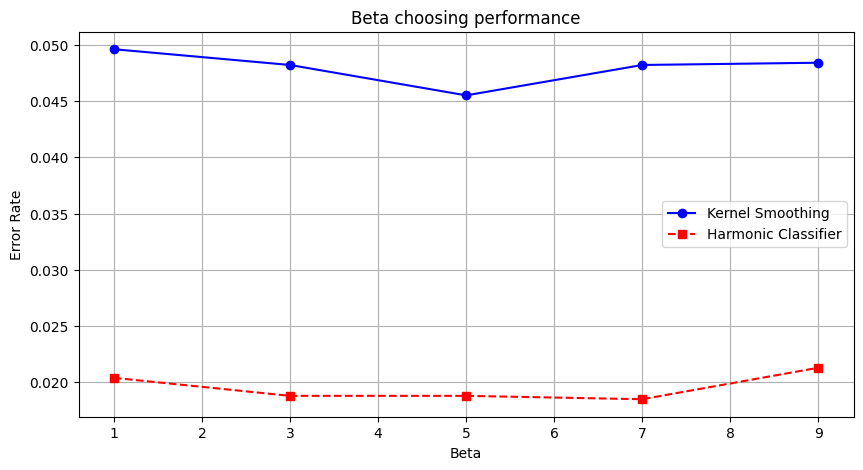

In [44]:
# Plotting
beta = [1,3,5,7,9]
plt.figure(figsize=(10, 5))
plt.plot(list(beta), error_rates_kernel_3, marker='o', linestyle='-', color='blue', label='Kernel Smoothing')
plt.plot(list(beta), error_rates_harmonic_3, marker='s', linestyle='--', color='red', label='Harmonic Classifier')
plt.title('Beta choosing performance')
plt.xlabel('Beta')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()


In [55]:
print(error_rates_harmonic_3)

[0.0204, 0.0188, 0.0188, 0.0185, 0.0213]


In [46]:
print(W)

  (0, 0)	0.9999999999999996
  (0, 1482)	0.180098915035582
  (0, 1516)	0.14745304989506536
  (0, 1634)	0.3956718480533533
  (0, 1978)	0.13054598826469438
  (0, 5210)	0.16838452369874118
  (0, 5688)	0.15074695449578138
  (0, 6198)	0.1503988059551951
  (0, 8642)	0.11762714765080616
  (0, 8728)	0.19299951103725713
  (0, 9652)	0.204537410446321
  (1, 1)	0.9999999999999964
  (1, 21)	0.18030573194854116
  (1, 639)	0.5481444010817811
  (1, 860)	0.3838882021238924
  (1, 1605)	0.4985827976960493
  (1, 2082)	0.18274152863475146
  (1, 2581)	0.4581394046454011
  (1, 2617)	0.36423033895103374
  (1, 3135)	0.3928719576569039
  (1, 3286)	0.15497073011427023
  (1, 4159)	0.3691252624197689
  (1, 4265)	0.10716442678991238
  (1, 4981)	0.17774004685610545
  (1, 5096)	0.15090586980480605
  :	:
  (9998, 6382)	0.5792086667888107
  (9998, 7110)	0.17944092022098987
  (9998, 7258)	0.20644388087583296
  (9998, 7505)	0.19368893293093095
  (9998, 9728)	0.15069540342549492
  (9998, 9998)	0.9999999999999992
  (9999, 8

In [47]:
W2 = compute_adapted_weights(img,K,labels,labeled_indices, beta = 5, k=9, m=8)
K2 = random_walk(W2)


In [48]:
print(W2)

  (0, 0)	0.9999999999999996
  (0, 1482)	0.18009891503555342
  (0, 1516)	0.14745304989505523
  (0, 1634)	0.39567184805302974
  (0, 1978)	0.1305459882648461
  (0, 5210)	0.16838452369872695
  (0, 5688)	0.1507469544958194
  (0, 6198)	0.15039880595539032
  (0, 8642)	0.11762714765078834
  (0, 8728)	0.19299951103720817
  (0, 9652)	0.20453741044633822
  (1, 1)	0.9999999999999964
  (1, 21)	0.18030573194854094
  (1, 639)	0.5481444010817811
  (1, 860)	0.38388820212389246
  (1, 1605)	0.4985827976960489
  (1, 2082)	0.18274152863475143
  (1, 2581)	0.45813940464540137
  (1, 2617)	0.36423033895103357
  (1, 3135)	0.3928719576569035
  (1, 3286)	0.15497073011427023
  (1, 4159)	0.3691252624197689
  (1, 4265)	0.10716442678991238
  (1, 4981)	0.17774004685610528
  (1, 5096)	0.150905869804806
  :	:
  (9998, 6382)	0.5792086667888078
  (9998, 7110)	0.17944092022098931
  (9998, 7258)	0.20644388087583215
  (9998, 7505)	0.19368893293093753
  (9998, 9728)	0.1506954034254981
  (9998, 9998)	0.9999999999999992
  (9999

In [60]:
prob = kernel_smooth(labels, labeled_indices, W2, iterations=20)
predicted_classes = np.argmax(predicted_probabilities, axis=1)
print(predicted_classes)



[5 0 4 ... 6 9 7]


In [62]:
error = calculate_error(predicted_classes,labels,0,10000)
error

0.0746

In [68]:
num_labels = 500
labeled_indices = np.arange(num_labels)

iterations_list = range(5, 100, 10)
error_rates_kernel_4 = []
error_rates_harmonic_4 = []

# Running loop for kernel_smooth
for iters in iterations_list:
    predicted_probabilities = kernel_smooth(labels, labeled_indices, W2, iterations=iters)
    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    error_kernel = calculate_error(predicted_labels, labels, 0, 10000)
    print(error_kernel)
    error_rates_kernel_4.append(error_kernel)
    print(f'Kernel Smoothing Error at {iters} iterations: {error_kernel}')

# Running loop for harmonic_classifier
for iters in iterations_list:
    predicted_probabilities_h = harmonic_classifier(labels, labeled_indices, K2, iters)
    predicted_labels_h = np.argmax(predicted_probabilities_h, axis=1)
    error_harmonic = calculate_error(predicted_labels_h, labels, 0, 10000)
    error_rates_harmonic_4.append(error_harmonic)
    print(f'Harmonic Classifier Error at {iters} iterations: {error_harmonic}')




0.065
Kernel Smoothing Error at 5 iterations: 0.065
0.0619
Kernel Smoothing Error at 15 iterations: 0.0619
0.074
Kernel Smoothing Error at 25 iterations: 0.074
0.0884
Kernel Smoothing Error at 35 iterations: 0.0884
0.0954
Kernel Smoothing Error at 45 iterations: 0.0954
0.1007
Kernel Smoothing Error at 55 iterations: 0.1007
0.1084
Kernel Smoothing Error at 65 iterations: 0.1084
0.115
Kernel Smoothing Error at 75 iterations: 0.115
0.1235
Kernel Smoothing Error at 85 iterations: 0.1235
0.1303
Kernel Smoothing Error at 95 iterations: 0.1303
Harmonic Classifier Error at 5 iterations: 0.0792
Harmonic Classifier Error at 15 iterations: 0.0561
Harmonic Classifier Error at 25 iterations: 0.0537
Harmonic Classifier Error at 35 iterations: 0.052
Harmonic Classifier Error at 45 iterations: 0.0516
Harmonic Classifier Error at 55 iterations: 0.0518
Harmonic Classifier Error at 65 iterations: 0.0519
Harmonic Classifier Error at 75 iterations: 0.0519
Harmonic Classifier Error at 85 iterations: 0.0518


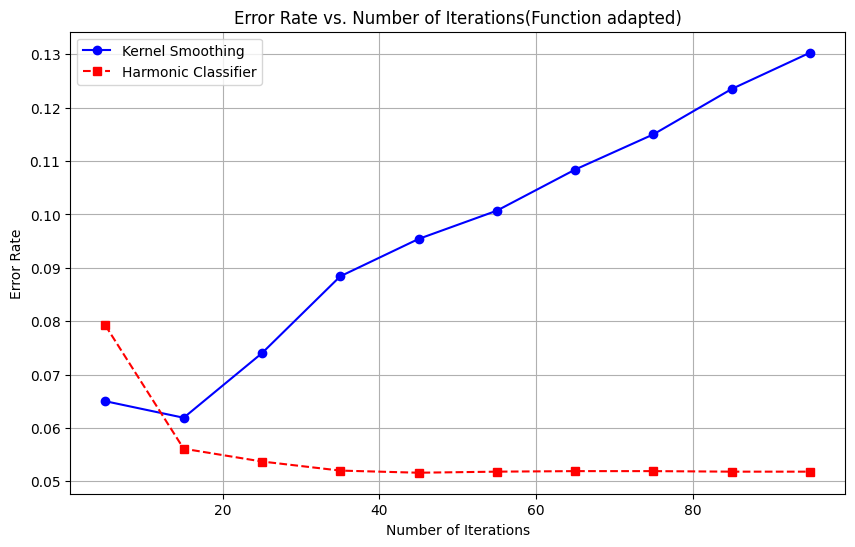

In [69]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(list(iterations_list), error_rates_kernel_4, marker='o', linestyle='-', color='blue', label='Kernel Smoothing')
plt.plot(list(iterations_list), error_rates_harmonic_4, marker='s', linestyle='--', color='red', label='Harmonic Classifier')
plt.title('Error Rate vs. Number of Iterations(Function adapted)')
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

In [56]:

num_labeled = [100, 250, 500, 1000, 2500, 5000]
num_split = 10
error_rates_kernel_5 = []
error_rates_harmonic_5 = []

for num in num_labeled:
    labeled_indices, unlabeled_indices = data_split(10000, num, num_split)

    predicted_probabilities = kernel_smooth(labels, labeled_indices, W2, iterations=50)
    predicted_probabilities_h = harmonic_classifier(labels, labeled_indices, K2, iterations=50)

    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    predicted_labels_h = np.argmax(predicted_probabilities_h, axis=1)

    error_kernel = calculate_error(predicted_labels, labels, 0, 10000)
    error_harmonic = calculate_error(predicted_labels_h, labels, 0, 10000)

    error_rates_kernel_5.append(error_kernel)
    error_rates_harmonic_5.append(error_harmonic)
    print(f'Kernel Error for {num} labeled data: {error_kernel}')
    print(f'Harmonic Error for {num} labeled data: {error_harmonic}')





Kernel Error for 100 labeled data: 0.0737
Harmonic Error for 100 labeled data: 0.0412
Kernel Error for 250 labeled data: 0.0742
Harmonic Error for 250 labeled data: 0.0291
Kernel Error for 500 labeled data: 0.0713
Harmonic Error for 500 labeled data: 0.0197
Kernel Error for 1000 labeled data: 0.0774
Harmonic Error for 1000 labeled data: 0.0104
Kernel Error for 2500 labeled data: 0.0743
Harmonic Error for 2500 labeled data: 0.0014
Kernel Error for 5000 labeled data: 0.0746
Harmonic Error for 5000 labeled data: 0.0001


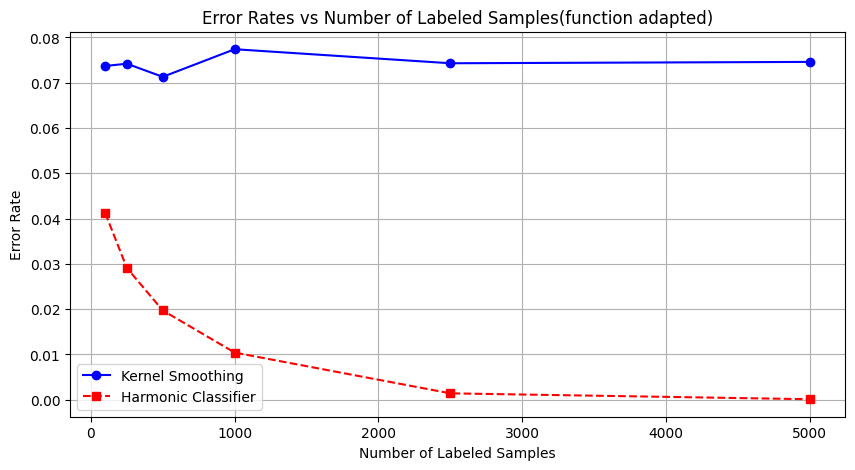

In [57]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(list(num_labeled), error_rates_kernel_5, marker='o', linestyle='-', color='blue', label='Kernel Smoothing')
plt.plot(list(num_labeled), error_rates_harmonic_5, marker='s', linestyle='--', color='red', label='Harmonic Classifier')
plt.title('Error Rates vs Number of Labeled Samples(function adapted)')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()



In [71]:
k = 9
m = 8
sigma = 1

# number of labeled data
num_labeled = [100, 250, 500, 1000, 2500, 5000]

Text(0.5, 1.0, 'Runtime of Graph Construction vs. Number of Data')

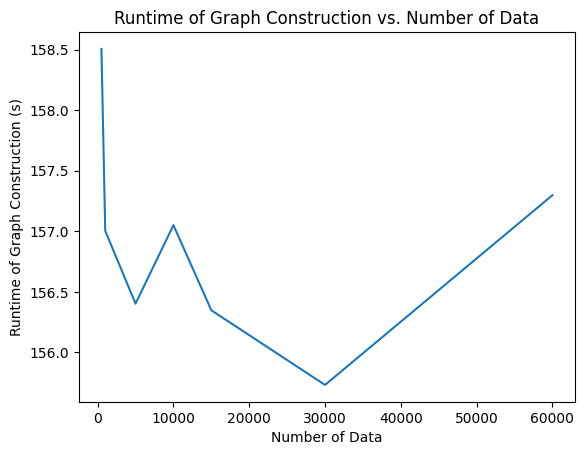

In [73]:
# runtime of graph construction with different total number
time_graph_construction = []
num_img = [500, 1000, 5000, 10000, 15000, 30000, 60000]
for num in num_img:
    data = data_pca[:num]
    s = time.process_time()
    W2 = compute_adapted_weights(img,K,labels,labeled_indices, beta = 5, k=9, m=8)
    time_construction = time.process_time() - s
    time_graph_construction.append(time_construction)

plt.figure()
plt.plot(num_img, time_graph_construction)
plt.xlabel('Number of Data')
plt.ylabel('Runtime of Graph Construction (s)')
plt.title('Runtime of Graph Construction vs. Number of Data')